## Programming Exercise 1: Linear Regression

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
from numpy.linalg import inv

### 2 Linear regression with one variable

In [2]:
data = 'data/FoodTruckProfitData.txt'
cols = np.loadtxt(data, delimiter=',', usecols=(0, 1), unpack=True) # read in comma separated data

# form the usual 'X' matrix and 'y' vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples

# insert the usual column of 1's into the 'X' matrix
X = np.insert(X, 0, 1, axis=1)

#### 2.1 Plotting the Data

Text(0, 0.5, 'Profit in $10,000s')

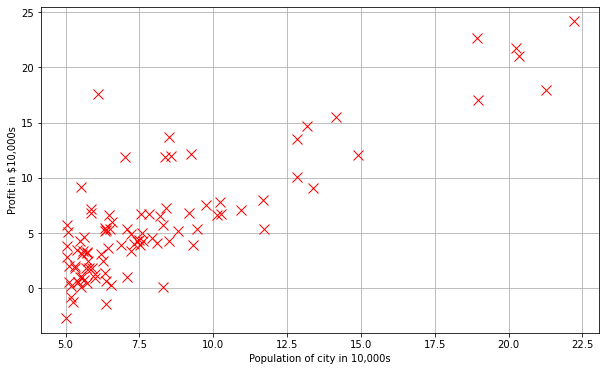

In [3]:
# plot the data to see what it looks like
plt.figure(figsize=(10, 6))
plt.plot(X[:, 1], y[:, 0], 'rx', markersize=10)
plt.grid(True) # always plot.grid as true!
plt.xlabel('Population of city in 10,000s')
plt.ylabel('Profit in $10,000s')

#### 2.2 Gradient Descent

In [4]:
iterations = 1500
alpha = 0.01

In [5]:
def hypothesis(theta, X):
    # linear hypothesis function
    return np.dot(X, theta)

In [6]:
def cost_function(theta, X, y):
    '''
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    '''

    # note: *.shape is (rows, columns)
    h = hypothesis(theta, X)
    return float((1 / (2*m)) * np.dot((h - y).T, h - y))

In [7]:
# test cost_function with 0's as theta should return 32.07(approx)
initial_theta = np.zeros((X.shape[1], 1)) # (theta is a vector with n rows and 1 column (when X has n features))
print(cost_function(initial_theta, X, y))

32.072733877455676


In [8]:
# actual gradient descent minimizing routine
def gradient_descent(X, theta_start=np.zeros(2)):
    '''
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    '''
    theta = theta_start
    j_vec = [] # used to plot cost as function of iteration
    theta_history = [] # used to visualize the minimization path later on

    for _ in range(iterations):
        temp_theta = theta
        j_vec.append(cost_function(theta, X, y))
        # buggy line
        # theta_history.append(list(temp_theta))
        # fixed line
        theta_history.append(list(theta[:, 0]))

        # simultaneously update theta values
        for j in range(len(temp_theta)):
            temp_theta[j] = theta[j] - (alpha / m) * np.sum((hypothesis(theta, X) - y) * np.array(X[:, j]).reshape(m, 1))
            # end inner for loop

        theta = temp_theta
        # end outer for loop
    
    return theta, theta_history, j_vec

In [9]:
# actually run gradient descent to get the best-fit theta values
initial_theta = np.zeros((X.shape[1], 1))
theta, theta_history, j_vec = gradient_descent(X, initial_theta)

In [10]:
# plot the convergence of the cost function
def plot_convergence(j_vec):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(j_vec)), j_vec, 'bo')
    plt.grid(True)
    plt.title('Convergence of Cost value')
    plt.xlabel('Iteration count')
    plt.ylabel('Cost value')

    dummy = plt.xlim([-0.05 * iterations, 1.05 * iterations])
    # dummy = plt.ylim([4, 8])

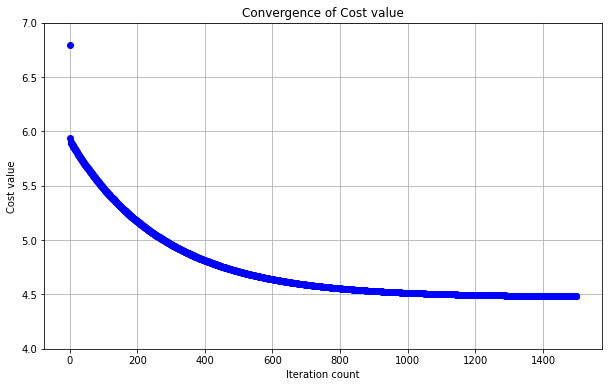

In [11]:
plot_convergence(j_vec)
dummy = plt.ylim([4, 7])

In [12]:
# plot the line on top of the data to ensure it looks correct
def best_fit(x_val):
    return theta[0] + theta[1] * x_val

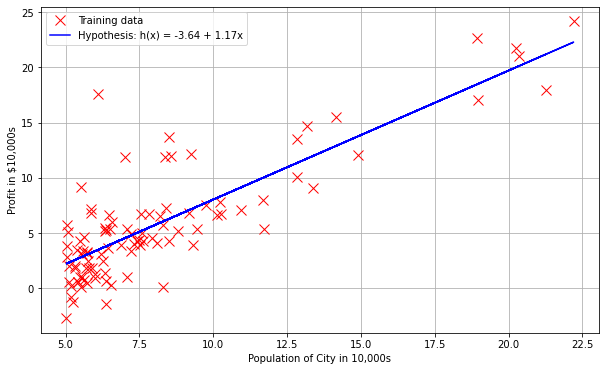

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(X[:, 1], y[:, 0], 'rx', markersize=10, label='Training data')
plt.plot(X[:, 1], best_fit(X[:, 1]), 'b-', label='Hypothesis: h(x) = %0.2f + %0.2fx'%(theta[0], theta[1]))
plt.grid(True)
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.legend()

#### 2.4 Visualizing _J($\theta$)_

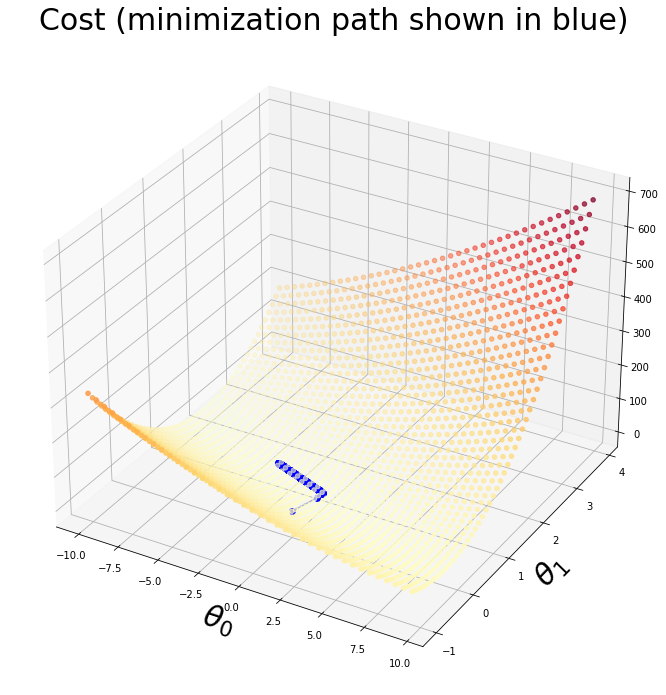

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

x_vals = np.arange(-10, 10, 0.5)
y_vals = np.arange(-1, 4, 0.1)
xs, ys, zs = [], [], []

for i in x_vals:
    for j in y_vals:
        xs.append(i)
        ys.append(j)
        zs.append(cost_function(np.array([[i], [j]]), X, y))

scat = ax.scatter(xs, ys, zs, c=np.abs(zs), cmap=plt.get_cmap('YlOrRd'))

plt.xlabel(r'$\theta_0$', fontsize=30)
plt.ylabel(r'$\theta_1$', fontsize=30)
plt.title('Cost (minimization path shown in blue)', fontsize=30)
plt.plot([x[0] for x in theta_history], [x[1] for x in theta_history], j_vec, 'bo-')
plt.show()

### 3. Linear Regression with multiple variables

In [15]:
data = 'data/HousingPriceData.txt'

# read into the data file
cols = np.loadtxt(data, delimiter=',', usecols=(0, 1, 2), unpack=True) # read in comma separated data

# form the usual 'X' matrix and 'y' vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples

# insert the usual column of 1's into the 'X' matrix
X = np.insert(X, 0, 1, axis=1)

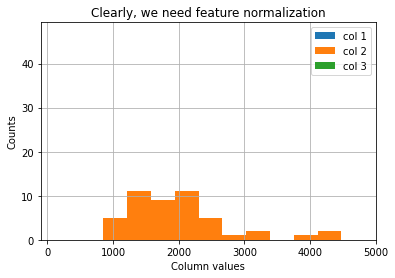

In [16]:
# quick visualization of data
plt.grid(True)
plt.xlim([-100, 5000])
dummy = plt.hist(X[:, 0], label='col 1')
dummy = plt.hist(X[:, 1], label='col 2')
dummy = plt.hist(X[:, 2], label='col 3')

plt.title('Clearly, we need feature normalization')
plt.xlabel('Column values')
plt.ylabel('Counts')

dummy = plt.legend()

In [17]:
# feature normalizing the columns (subtract mean, divide by standard deviation)
# store the mean and std for later use
# note: don't modify the original X matrix, use a copy
stored_feature_means, stored_feature_stds = [], []
X_norm = X.copy()

for col in range(X_norm.shape[1]):
    stored_feature_means.append(np.mean(X_norm[:, col]))
    stored_feature_stds.append(np.std(X_norm[:, col]))

    # skip the first column
    if not col:
        continue

    # faster to not recompute the mean and std again, just used stored values
    X_norm[:, col] = (X_norm[:, col] - stored_feature_means[-1]) / stored_feature_stds[-1]

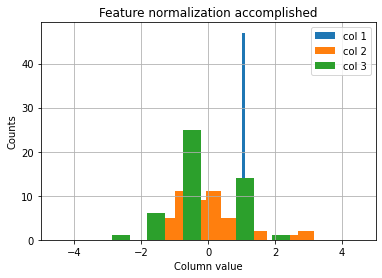

In [18]:
# quick visualization of the feature-normalized data
plt.grid(True)
plt.xlim([-5, 5])
dummy = plt.hist(X_norm[:, 0], label='col 1')
dummy = plt.hist(X_norm[:, 1], label='col 2')
dummy = plt.hist(X_norm[:, 2], label='col 3')

plt.title('Feature normalization accomplished')
plt.xlabel('Column value')
plt.ylabel('Counts')

dummy = plt.legend()

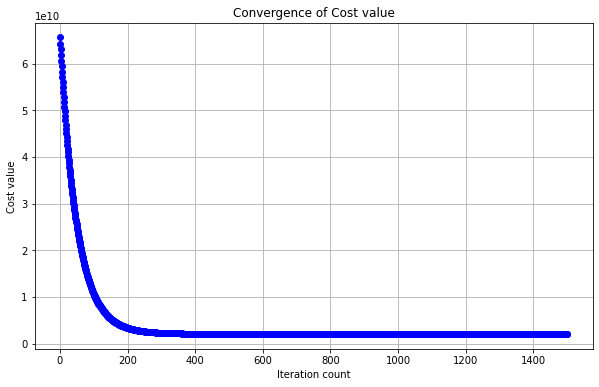

In [19]:
# run gradient descent with multiple variables, initial theta still set to zeros
# (note! this doesn't work unless we feature normalize! 'overflow encountered in multiply')
initial_theta = np.zeros((X_norm.shape[1], 1))
theta, theta_history, j_vec = gradient_descent(X_norm, initial_theta)

# plot convergence of cost function
plot_convergence(j_vec)

In [20]:
# print('final result theta parameters: \n', theta)
print('Result check: What is the price of house with 1650 square feet and 3 bedrooms?')
y_test = np.array([1650, 3])

# to 'undo' feature normalization, we 'undo' 1650 and 3, then plug it into our hypothesis
y_test_result = [(y_test[x] - stored_feature_means[x+1]) / stored_feature_stds[x+1] for x in range(len(y_test))]
y_test_result.insert(0, 1)
print('$%0.2f'%float(hypothesis(theta, y_test_result)))

Result check: What is the price of house with 1650 square feet and 3 bedrooms?
$293098.15


In [21]:
# implementation of normal equation to find analytic solution to linear regression
def normal_equations(X, y):
    # res_theta = np.zeros((X.shape[1], 1))
    return np.dot(np.dot(inv(np.dot(X.T, X)), X.T), y)

In [22]:
print('Normal equation prediction for price of house with 1650 square feet abd 3 bedrooms')
print('$%0.2f'%float(hypothesis(normal_equations(X, y), [1, 1650, 3])))

Normal equation prediction for price of house with 1650 square feet abd 3 bedrooms
$293081.46
